In [38]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier

from sklearn import metrics
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import numpy as np

path_red = 'data/winequality-red.csv'
path_white = 'data/winequality-white.csv'

# classifier info
# full_acc - accuracy score with initial number of features (in this case the number is 11)
# cut_acc - accuracy score after feature selection (here we cut them down to 4)
# we need these accuracy scores in orer to compare the results
class Classifier:
    def __init__(self, name, content, full_acc=0, cut_acc=0):
        self.name = name
        self.content = content

# read .csv file containing our dataset where:
# X - features
# y - labels
def get_raw_data (filepath):
    raw_data = np.genfromtxt(filepath, delimiter=';', skip_header=1)
    
    X = raw_data[:,:raw_data.shape[1]-1]
    y = raw_data[:,raw_data.shape[1]-1]
    
    return X, y

# either just split the dataset into train and test ones or select features before splitting
def prep_data (filepath, num_of_feats=None):
    
    data, target = get_raw_data(filepath)
    if num_of_feats:
        data = SelectKBest(chi2, k=num_of_feats).fit_transform(data, target)
        
    return train_test_split(data, target, test_size=0.3, random_state=1)

# 'classifiers' collects all the classifiers used to predict wine quality
# they already have all the parameters set
classifiers = [Classifier('SVM', SVC(kernel='rbf', gamma='scale')), 
               Classifier('Naive bayes', GaussianNB()),
               Classifier('Decision tree', DecisionTreeClassifier(max_depth=5)), 
               Classifier('Random forest', RandomForestClassifier(n_estimators=10)), 
               Classifier('Ada boost', AdaBoostClassifier()), 
               Classifier('Extra trees', ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=4, random_state=0))]

# the method that starts the proccess and connects all the other parts
def run (filepath=path_red, wine_sort='RED'):
    
    X_train, X_test, y_train, y_test = prep_data(filepath)
    print(f'Data analysis for {wine_sort} wine before feature selection (number of features={X_train.shape[1]})\n')

    # get predictions with an initial number of features and save accuracy scores for each classifier
    # this method also shows metrics (accuracy score and confusion matrix)
    for clf in classifiers:
        classifiers[classifiers.index(clf)].full_acc = train_and_predict(clf.content, clf.name, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
        
    # here we get feature importances for ensemble algorithms to find out how many features we will select further
    for clf in classifiers[-3:]:
        show_feature_importances(clf.content, clf.name, X_train)
        
    # feature selection gives the dataset with 4 features
    X_new_train, X_new_test, y_train, y_test = prep_data(filepath, 4)
    print(f'Data analysis for {wine_sort} wine after feature selection (number of features={X_new_train.shape[1]})\n')

    # get predictions again after feature selection, save accuracy scores for each classifier and show metrics
    for clf in classifiers:
        classifiers[classifiers.index(clf)].cut_acc = train_and_predict(clf.content, clf.name, X_train=X_new_train, X_test=X_new_test, y_train=y_train, y_test=y_test)
    
    # show both accuracy scores for each classifier
    get_accuracy_scores(classifiers, wine_sort)

# create classifier, train it and predict wine quality
def train_and_predict (classifier, clf_name, X_train=[], y_train=[], X_test=[], y_test=[]):
    
    classifier = classifier
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    
    show_metrics(y_test, y_pred, clf_name)
    
    return metrics.accuracy_score(y_test, y_pred)

# show metrics: accuracy score and confusion matrix
def show_metrics (y_test, y_pred, clf_name):
    
    print(f'{clf_name} accuracy: {metrics.accuracy_score(y_test, y_pred)}')
    
    cm = confusion_matrix(y_test, y_pred)

    merged = np.append(y_test, y_pred)
    classes = np.unique(merged.astype('int32'))
    
    cmap=plt.cm.Blues
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=clf_name+' confusion matrix',
           ylabel='True label',
           xlabel='Predicted label')
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right',
             rotation_mode='anchor')

    fmt = 'd'
    thresh = cm.max() / 2.
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')
    
    plt.show()

# get and show feature importances for ensemble methods to detect the number of features that will be selected further
def show_feature_importances (classifier, clf_name, X=None):
    importances = classifier.feature_importances_
    std = np.std([tree.feature_importances_ for tree in classifier.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    plt.figure()
    plt.title(clf_name+" feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()

# show both accuracy scores (before and after feature selection) for each classifier 
def get_accuracy_scores (clfs, wine_sort):
    title = 'Accuracy data for '+wine_sort+' wine'
    col_name = 'classifier'
    print(f'{title:>35}\n')
    print(f'{col_name:>15} | full acc | cut acc')
    for clf in clfs:
        print(f'{clf.name:>15} | {round(clf.full_acc,4):<8} | {round(clf.cut_acc,4)}')

Data analysis for RED wine before feature selection (number of features=11)

SVM accuracy: 0.5208333333333334


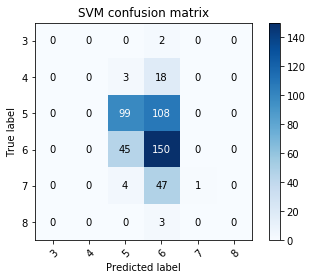

Naive bayes accuracy: 0.5416666666666666


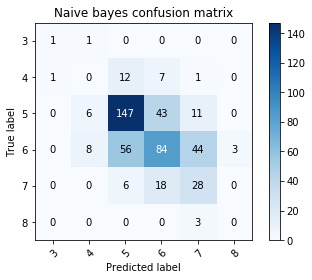

Decision tree accuracy: 0.58125


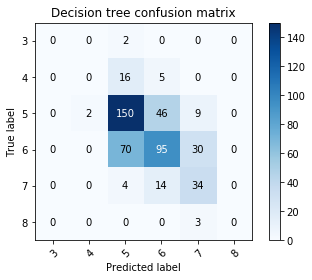

Random forest accuracy: 0.6666666666666666


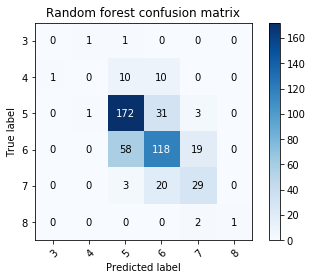

Ada boost accuracy: 0.5666666666666667


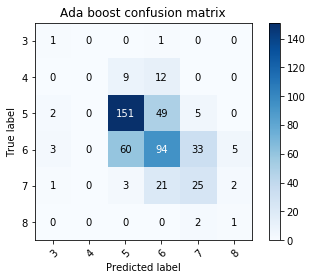

Extra trees accuracy: 0.7083333333333334


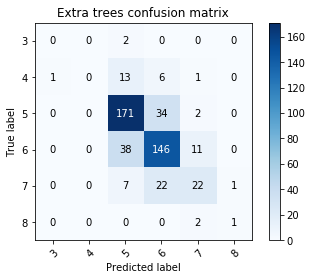

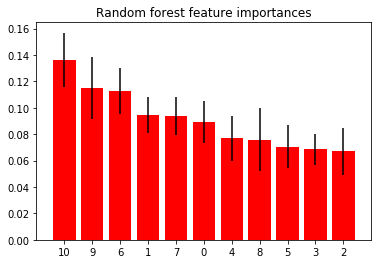

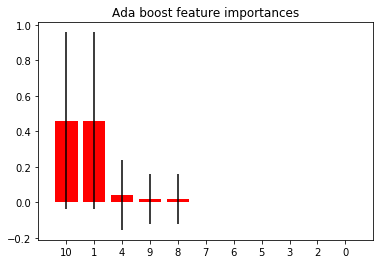

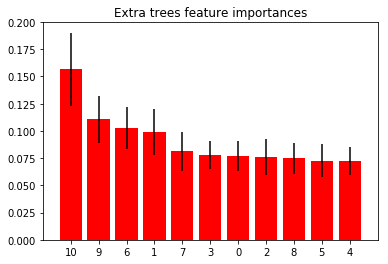

Data analysis for RED wine after feature selection (number of features=4)

SVM accuracy: 0.5166666666666667


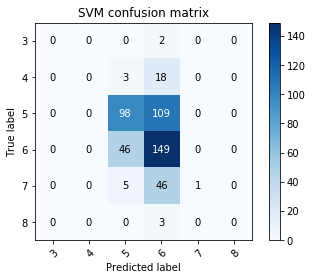

Naive bayes accuracy: 0.5895833333333333


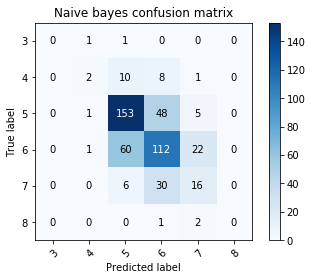

Decision tree accuracy: 0.5854166666666667


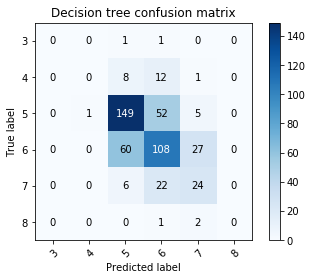

Random forest accuracy: 0.6458333333333334


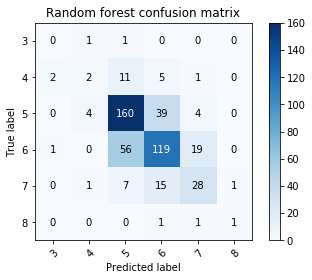

Ada boost accuracy: 0.5708333333333333


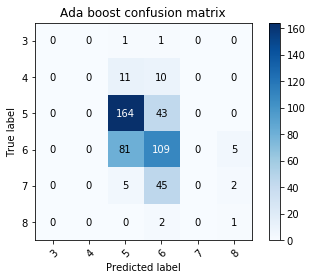

Extra trees accuracy: 0.66875


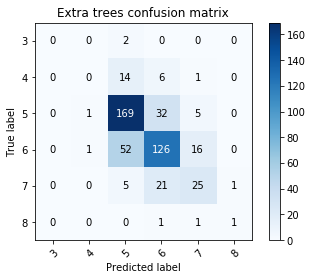

         Accuracy data for RED wine

     classifier | full acc | cut acc
            SVM | 0.5208   | 0.5167
    Naive bayes | 0.5417   | 0.5896
  Decision tree | 0.5812   | 0.5854
  Random forest | 0.6667   | 0.6458
      Ada boost | 0.5667   | 0.5708
    Extra trees | 0.7083   | 0.6688


In [39]:
run(path_red, 'RED')

Data analysis for WHITE wine before feature selection (number of features=11)

SVM accuracy: 0.44693877551020406


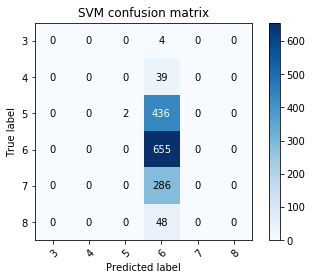

Naive bayes accuracy: 0.454421768707483


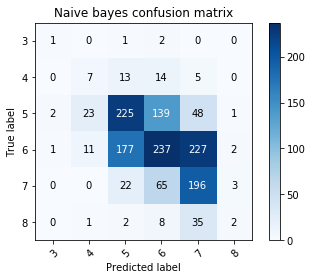

Decision tree accuracy: 0.5251700680272109


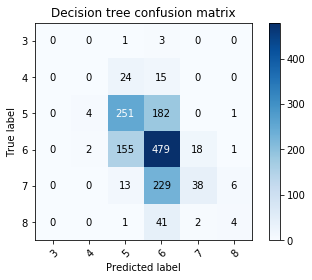

Random forest accuracy: 0.6408163265306123


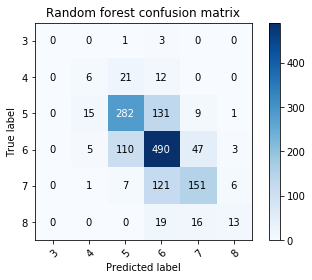

Ada boost accuracy: 0.43673469387755104


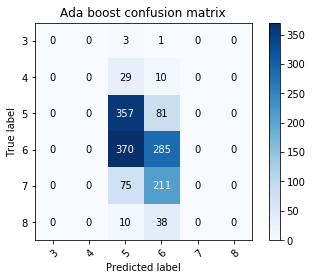

Extra trees accuracy: 0.6789115646258503


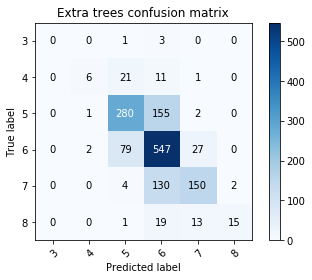

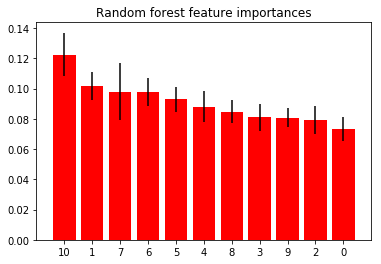

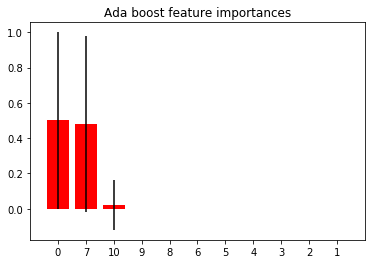

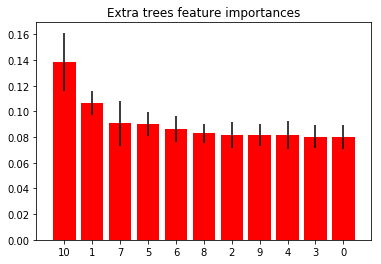

Data analysis for WHITE wine after feature selection (number of features=4)

SVM accuracy: 0.454421768707483


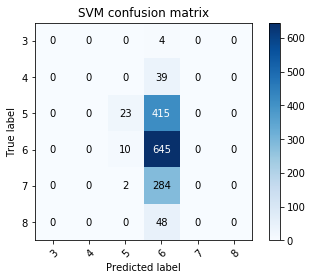

Naive bayes accuracy: 0.4639455782312925


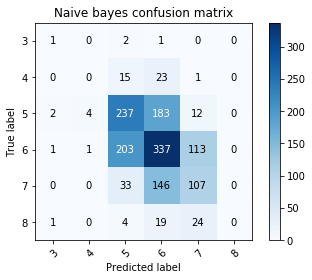

Decision tree accuracy: 0.49115646258503404


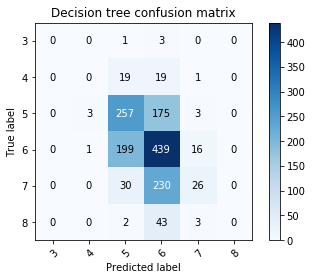

Random forest accuracy: 0.6183673469387755


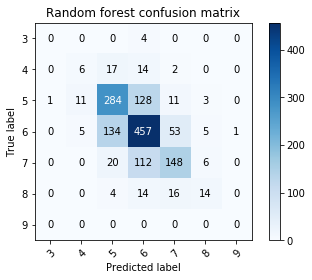

Ada boost accuracy: 0.45510204081632655


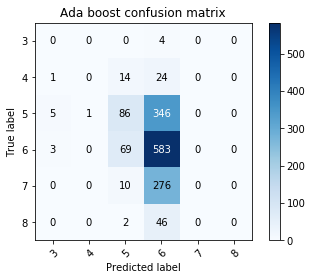

Extra trees accuracy: 0.6251700680272109


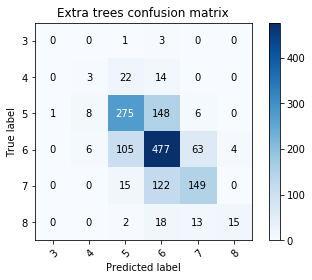

       Accuracy data for WHITE wine

     classifier | full acc | cut acc
            SVM | 0.4469   | 0.4544
    Naive bayes | 0.4544   | 0.4639
  Decision tree | 0.5252   | 0.4912
  Random forest | 0.6408   | 0.6184
      Ada boost | 0.4367   | 0.4551
    Extra trees | 0.6789   | 0.6252


In [40]:
run(path_white, 'WHITE')

## Findings 
* NB and support vector classifier got the lowest accuracy
* Decision tree classifier performed better than the previuos ones, so using ensemble methods makes sense
* among three ensemble algorithms the best ones were random forest and extra trees classifier
* increasing n_estimators from 10 to 100 improves Extra trees accuracy score but doesn't for random forest
* among ensemble methods used here Ada boost performed the lowest accuracy score
* looking at graphs showing feature importances we can see that for Ada boost classifier all the features except 3 (for white wine) or 5 (for red wine) just don't make sense and only add noise. For two other ensemble algorithms feature importances visibly decrease after 4/5 features. Based on this information we futher select 4 features and repeat model training and predicting to see if noise reduction improves the results
* Ada booset classifier accuracy score expectedly increased after feature selection, but it still performs comparable to non-ensemble classifiers
* as ensemple algorithms performed best before feature selection, we should pay close attention to their accuracy scores which worsened after feature selection. At feature importances graphs we can see that all features are approximately at the same level, so we shoudn't eliminate any of them
* the **highest accuracy** score is **0.708** (**Extra trees classifier** for red wine without feature selection)

* this low accuracy scores and relatively dense confusion matrixes for each classifier may be due to the fact that  there was not enough data (some test labels didn't occure) while training